In [2]:
# os.chdir(code_dir)
from analysis import *
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
code_dir = os.getcwd()
os.chdir('../..')


/home/tlogan/research/land_surface_temperature/code/analysis/analysis.py:8: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/usr/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/tlogan/research/land_surface_temperature/venv/lib/python3.5/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/tlogan/research/land_surface_temperature/venv/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/tlogan/research/land_surface_temperature/venv/lib/python3.5/site-pac

In [2]:
cities = ['bal', 'por', 'det', 'phx']
# import data
df = import_data(cities)

# data transformations
df = transform_data(df)

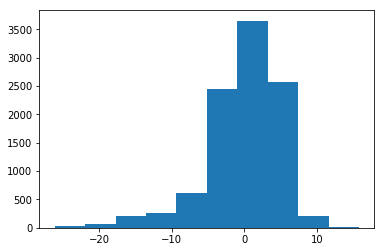

In [3]:
predict_quant = 'lst'
df2 = normalize_response(cities, df, predict_quant)
df2, response = prepare_lst_prediction(df)

response_keys = list(response.keys())
plt.hist(response[response_keys[0]])
plt.show()

# Train on Detroit, test on Baltimore

In [4]:
print(df.shape)
print(response.shape)

(10034, 86)
(10034, 6)


In [5]:
X_train = df2[df2['city']=='det']
X_test = df2[df2['city']=='bal']
y_train = response[df2['city']=='det']
y_test = response[df2['city']=='bal']

# Intra-city holdout

# Feature Selection

How long does it take to run a single regressor with all of the variables?

In [6]:
import time

start = time.time()
###
# train the model
###

df_city = df.copy()
# drop necessary variables
df_city, response = prepare_lst_prediction(df_city)
df_city = df_city.iloc[:,0:20]
variables = df_city.columns.values
print(variables)
# no need to divide, but split into X and y
X_train, X_test, y_train, y_test = train_test_split(df_city, response, test_size=0)#, random_state=RANDOM_SEED)
# scale explanatory variables
X_train, X_train  = scale_X(X_train, X_train)
# response values
y = define_response_lst(y_train, y_train)
# fit the model
gbm = GradientBoostingRegressor(max_depth=2, random_state=RANDOM_SEED, learning_rate=0.1, n_estimators=500, loss='ls')
gbm.fit(X_train, y['day_train'])

# time
end = time.time()
print(end - start)

['alb_mean_max' 'alb_mean_max_sl' 'alb_mean_mean' 'alb_mean_mean_sl'
 'alb_mean_min' 'alb_mean_min_sl' 'area' 'city' 'elev_max' 'elev_max_sl'
 'elev_mean' 'elev_mean_sl' 'elev_min' 'elev_min_sl' 'imp_max'
 'imp_max_sl' 'imp_mean' 'imp_mean_sl' 'imp_min' 'imp_min_sl']
3.9279065132141113


Given it takes ~6 seconds to fit the largest model, it would take

In [7]:
6*np.sum(range(20))/60

19.0

50 minutes to fit all of the models.
If I took the average MAE from 20 holdouts, that'd take < 20 hours.

In [14]:
import time

start = time.time()
city = 'bal'
period = 'night'
holdout_num = 2
'''
forward selection of variables based on OOB mae
'''
df_set, response = prepare_lst_prediction(df)
variables = df_set.columns.values
variables = [var for var in variables if var not in ['city','area']]
# subset for the city
if city != 'all':
    df_city = df[df['city']==city]
else:
    df_city = df.copy()
# drop necessary variables
df_city, response = prepare_lst_prediction(df_city)
# add variables based on which provide the best improvement to lowering MAE
vars_inc = []
vars_mae = []
while len(vars_inc)<len(variables):
    # loop through the Variables
    variables = [var for var in variables if var not in vars_inc]
    variable_mae = pd.DataFrame(index=variables, columns=['mae'])
    for var in variables:
        df_var = df_city.loc[:,[var,'city'] + vars_inc].copy()
        # initialize error measures
        mae = []
        for h in range(holdout_num):
            # no need to divide, but split into X and y
            X_train, X_test, y_train, y_test = train_test_split(df_var, response, test_size=0.2)#, random_state=RANDOM_SEED)
            # scale explanatory variables
            X_train, X_test  = scale_X(X_train, X_test)
            # response values
            y = define_response_lst(y_train, y_test)
            # fit the model
            gbm_day = GradientBoostingRegressor(max_depth=2, random_state=RANDOM_SEED, learning_rate=0.1, n_estimators=500, loss='ls')
            gbm_day.fit(X_train, y['{}_train'.format(period)])
            # predict the model
            predict_day = gbm_day.predict(X_test)
            # calculate MAE
            mae.append(np.mean(abs(predict_day - y['{}_test'.format(period)])))
        # calculate the average
        variable_mae.loc[var,'mae'] = np.mean(mae)
    # variable to include
    vars_inc.append(variables[variable_mae.loc[:,'mae'].values.argmin()])
    vars_mae.append(variable_mae.loc[:,'mae'].values.min())
# add to dict
var_forwardstep = pd.DataFrame({
    'variables':vars_inc,
    'mae':vars_mae
})
return(var_forwardstep)
# time
end = time.time()
print(end - start)


2592.4926719665527


When I do 25 holdouts, it takes 2592 seconds. Odd that the alb_mean_mean is the lowest ranked variable....

In [25]:
vars_mae
val, idx = min((val, idx) for (idx, val) in enumerate(vars_mae))
print(val,idx)

0.3448011188646132 14


In [32]:
var_forwardstep = pd.DataFrame({
    'variables':vars_inc,
    'mae':vars_mae
})
var_forwardstep

,mae,variables
0,0.719181,tree_mean
1,0.484759,ndvi_mean_mean
2,0.408469,elev_min_sl
3,0.362859,tree_max
4,0.354653,ndvi_mean_mean_sl
5,0.349833,tree_max_sl
6,0.349807,elev_mean_sl
7,0.354210,elev_mean
8,0.348039,tree_min
9,0.354165,imp_max


In [30]:
print('number of vars with MAE reported: {}'.format(len(vars_inc)))
# candidate variable number
df_set, response = prepare_lst_prediction(df)
variables = df_set.columns.values
variables = [var for var in variables if var not in ['city','area']]
print('number of candidate vars: {}'.format(len(variables)))

number of vars with MAE reported: 30
number of candidate vars: 30


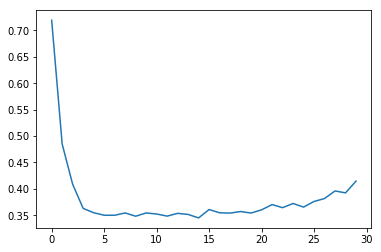

In [26]:
plt.plot(vars_mae)

The time it took for Baltimore night to evaluate all of the variables using a forward greedy algorithm with 25 holdouts, was 

In [27]:
2592/60

43.2

In [35]:
variable_mae

,mae
alb_mean_mean,0.414541


## Read in variable selection results

In [27]:
vars_forward['night']['bal']

,mae,variables
0,0.720355,imp_mean
1,0.480037,ndvi_mean_mean
2,0.410898,elev_mean_sl
3,0.367363,imp_max
4,0.357668,ndvi_mean_mean_sl
5,0.354481,elev_max
6,0.353580,ndvi_mean_min
7,0.353825,tree_mean_sl
8,0.360123,elev_min_sl
9,0.349010,imp_max_sl


In [36]:
vars_forward['night']['bal'].shape[0]

16

/home/tlogan/research/land_surface_temperature


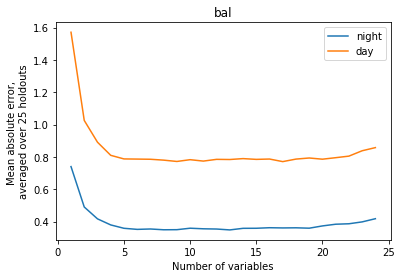

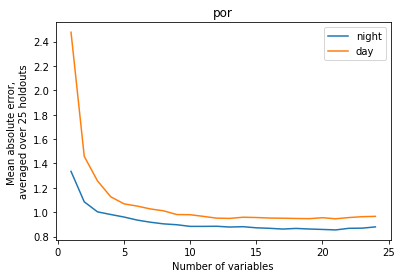

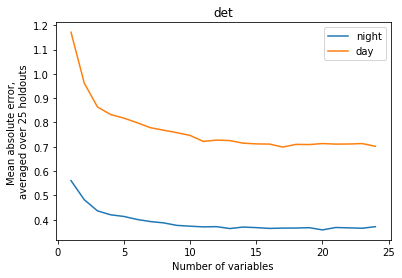

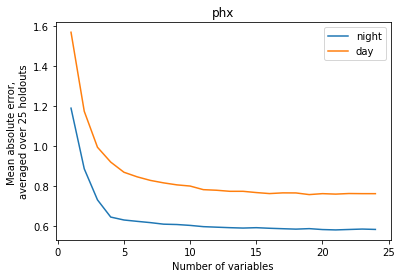

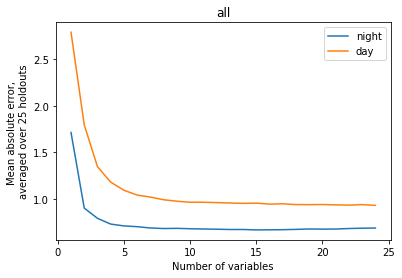

In [3]:
import pickle
import os
print(os.getcwd())
%matplotlib inline
with open('data/variable_selection.pkl', 'rb') as f:
        vars_forward = pickle.load(f)
cities = ['bal', 'por', 'det', 'phx', 'all']
range_variables = list(range(1,vars_forward['night']['bal'].shape[0]+1))
for city in cities:
    for period in ['night', 'day']:
        plt.plot(range_variables,vars_forward[period][city]['mae'], label = period)
    plt.ylabel('Mean absolute error, \naveraged over 25 holdouts')
    plt.xlabel('Number of variables')
    plt.legend(loc='upper right')
    plt.title(city)
    plt.show()

In [10]:
vars_forward['night']['det']

,mae,variables
0,0.561012,tree_mean
1,0.482515,ndvi_mean_mean
2,0.436636,elev_mean_sl
3,0.420451,alb_mean_min_sl
4,0.413646,alb_mean_max
5,0.401307,tree_max_sl
6,0.392638,alb_mean_mean
7,0.387256,ndvi_mean_mean_sl
8,0.376956,tree_mean_sl
9,0.373606,elev_min


## Variable importance

In [ ]:
list(reg_gbm['covariates'])

In [ ]:
cities = ['bal', 'por', 'det', 'phx']
cities = cities.copy()
cities.append('all')
five_thirty_eight = [
    "#30a2da",
    "#fc4f30",
    "#e5ae38",
    "#6d904f",
    "#8b8b8b",
]
# get the covariates - these will be the indices in the dataframe
header = pd.MultiIndex.from_product([['nocturnal','diurnal'],cities],
                                names=['time','city'])
var_imp = pd.DataFrame(columns = header, index = list(reg_gbm['covariates']))
print(var_imp.shape)
for city in cities:
    for time in ['diurnal','nocturnal']:
        var_imp.loc[:,(time, city)] = reg_gbm[time][city].feature_importances_
var_imp.loc[:,('nocturnal','mean')] = np.mean(var_imp.loc[:,'nocturnal'].drop('all',axis=1),axis=1)
var_imp = var_imp.sort_values(by=('nocturnal','mean'),ascending=False)
# make the nocturnal values negative
nocturnal = var_imp.loc[:,'nocturnal'].copy()
nocturnal = nocturnal.drop('mean',axis=1)
nocturnal['covariate'] = nocturnal.index
nocturnal = pd.melt(nocturnal,id_vars=['covariate'])
nocturnal.loc[:,'value'] = nocturnal['value'] * -1
# diurnal
diurnal = var_imp.loc[:,'diurnal'].copy()
diurnal.loc[:,'covariate'] = diurnal.index
diurnal = pd.melt(diurnal,id_vars=['covariate'])
# plot
ax = sns.barplot(orient="h", y='covariate', x='value',hue='city', data=nocturnal, palette = five_thirty_eight)

ax = sns.barplot(orient="h", y='covariate', x='value',hue='city', data=diurnal, palette = five_thirty_eight)
handles, labels = ax.get_legend_handles_labels()
plt.xlabel('Variable Importance')
plt.ylabel('Variables')
l = plt.legend(handles[0:4], labels[0:4], loc='lower right')
# mpl.rcParams['figure.figsize'] = 10, 20
# zero line
plt.axvline(x=0, color='k', linestyle='-', linewidth = 2)
plt.xlim(-0.2,0.2)

plt.show()
# plt.clf()


In [36]:
cities = ['bal', 'por', 'det', 'phx']
for city in cities+['all']:
    print(city)

bal
por
det
phx
all


In [37]:
from datetime import datetime
print('{}: completed {}, {}'.format(datetime.now().strftime('%Y-%m-%d %H:%M:%S'), city, period))

2018-04-25 00:07:39: completed all, night


In [39]:
import pickle
with open('data/variable_selection.pkl', 'wb') as f:
    pickle.dump(var_forwardstep, f, pickle.HIGHEST_PROTOCOL)

# which variables
Based on the output of the variable selection, I want to look at the variables that were included first, for each of the different models and times

In [1]:
# import the vars_forward object

from analysis import *
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

with open('../../data/variable_selection.pkl', 'rb') as f:
        vars_forward = pickle.load(f)

# create a database with the variable names
cities = ['bal', 'por', 'det', 'phx', 'all']
times = ['night', 'day']
db_var = pd.DataFrame()
for city in cities:
    for day in times:
        db_var['{}-{}'.format(city,day)] = vars_forward[day][city]['variables']
db_var

,bal-night,bal-day,por-night,por-day,det-night,det-day,phx-night,phx-day,all-night,all-day
0,tree_mean,tree_mean,tree_mean,alb_mean_mean,tree_mean,tree_mean,tree_mean,tree_mean,elev_min_sl,elev_mean
1,ndvi_mean_mean,ndvi_mean_mean,elev_mean,tree_mean,ndvi_mean_mean,elev_min_sl,ndvi_mean_mean,ndvi_mean_mean,tree_mean,tree_mean
2,elev_min_sl,tree_max,ndvi_mean_mean,ndvi_mean_mean,elev_mean_sl,ndvi_mean_mean,elev_min_sl,elev_max,ndvi_mean_mean,ndvi_mean_mean
3,tree_max,elev_min_sl,tree_min_sl,elev_min,alb_mean_min_sl,elev_mean,elev_max,elev_min,elev_max,alb_mean_mean
4,ndvi_mean_mean_sl,alb_mean_mean_sl,alb_mean_mean,elev_max_sl,alb_mean_max,alb_mean_mean_sl,tree_max,alb_mean_mean,alb_mean_min,elev_min
5,ndvi_mean_min_sl,elev_mean,tree_mean_sl,tree_max,tree_max_sl,tree_max,alb_mean_min,ndvi_mean_min,elev_max_sl,alb_mean_min_sl
6,elev_min,ndvi_mean_min,elev_max_sl,elev_mean,alb_mean_mean,ndvi_mean_min_sl,tree_min,tree_min,tree_max,elev_max
7,ndvi_mean_min,ndvi_mean_mean_sl,elev_min_sl,alb_mean_min,ndvi_mean_mean_sl,ndvi_mean_mean_sl,alb_mean_max_sl,tree_max_sl,elev_min,tree_min
8,elev_mean,tree_max_sl,tree_max,ndvi_mean_min,tree_mean_sl,alb_mean_mean,elev_mean_sl,ndvi_mean_mean_sl,tree_min,tree_min_sl
9,elev_max_sl,tree_min,ndvi_mean_max,tree_min_sl,elev_min,alb_mean_min_sl,elev_max_sl,alb_mean_min_sl,ndvi_mean_max_sl,alb_mean_mean_sl


In [36]:
# to select the variables, i'm going to calculate the median index of each of them
var_list = pd.DataFrame(index=db_var['bal-night'].values)
for var in var_list.index:
    for city in cities:
        for day in times:
            col = '{}-{}'.format(city,day)
            var_list.loc[var, col] = np.where(db_var[col] == var)[0][0]
# make the day median, night median, and overall median. sort by overall median
var_list['median'] = var_list.median(axis=1)
var_list['mean'] = var_list.mean(axis=1)
var_list['median-day'] = var_list[[col for col in var_list.columns if 'day' in col]].median(axis=1)
var_list['median-night'] = var_list[[col for col in var_list.columns if 'night' in col]].median(axis=1)

var_list = var_list.sort_values(by='median')
var_list

,bal-night,bal-day,por-night,por-day,det-night,det-day,phx-night,phx-day,all-night,all-day,median,mean,median-day,median-night
tree_mean,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.272727,0.0,0.0
ndvi_mean_mean,1.0,1.0,2.0,2.0,1.0,2.0,1.0,1.0,2.0,2.0,1.5,1.500000,2.0,1.0
elev_min_sl,2.0,3.0,7.0,17.0,10.0,1.0,2.0,19.0,0.0,19.0,5.0,7.727273,17.0,2.0
tree_max,3.0,2.0,8.0,5.0,15.0,5.0,4.0,15.0,6.0,14.0,5.5,7.500000,5.0,6.0
elev_mean,8.0,5.0,1.0,6.0,14.0,3.0,17.0,13.0,10.0,0.0,7.0,7.636364,5.0,10.0
alb_mean_mean,23.0,23.0,4.0,0.0,6.0,8.0,10.0,4.0,22.0,3.0,7.0,10.000000,4.0,10.0
elev_min,6.0,19.0,14.0,3.0,9.0,13.0,18.0,3.0,7.0,4.0,8.0,9.454545,4.0,9.0
ndvi_mean_mean_sl,4.0,7.0,15.0,18.0,7.0,7.0,23.0,8.0,12.0,11.0,9.5,11.045455,8.0,12.0
tree_min,16.0,9.0,11.0,14.0,21.0,21.0,6.0,6.0,8.0,7.0,10.0,11.727273,9.0,11.0
elev_max_sl,9.0,15.0,6.0,4.0,13.0,19.0,9.0,17.0,5.0,20.0,11.0,11.636364,17.0,9.0


based on this I will probably take the first 6. although, potential need to think about the day vs night. but these effects should show when i compare the partial dependence plots

# Run regression with this variable subset and create the variable importance and partial dependence

In [11]:
import os
os.chdir('/home/tlogan/research/land_surface_temperature/code/analysis')
from analysis import *
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
code_dir = os.getcwd()
os.chdir('../..')

# loop cities and all
cities = ['bal', 'por', 'det', 'phx']
# import data
df = import_data(cities)
# data transformations
df = transform_data(df)
# based on the results of the variable selection, rerun the regression and
# create the variable importance plots
vars_selected = ['tree_mean', 'ndvi_mean_mean', 'elev_min_sl', 'tree_max', 'elev_mean', 'alb_mean_mean']
reg_gbm = full_gbm_regression(df, cities, vars_selected)

1004 0
1642 0
1579 0
5809 0
10034 0


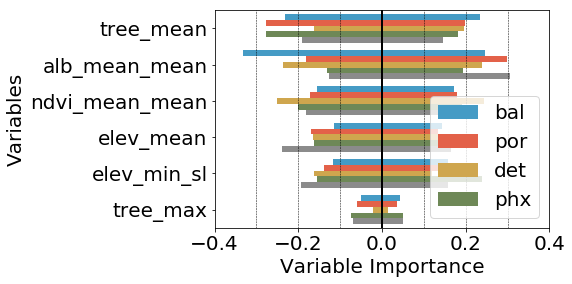

In [12]:
# plot the variable importance
plot_importance(reg_gbm, cities, show_plot=True)

In [ ]:
# plot the partial dependence plots
